# Preliminaries
Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [1]:
!pip freeze > kaggle_image_requirements.txt

# Read and Preprocess Fake News Data

The data preprocessing steps are the same as those in sections 4.2/4.4

Read in the "true" and "fake" data

In quotes, because that has the potential to simply replicate the biases of the labeler, so should be carefully evaluated

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Read the data into pandas DataFrames
DataTrue = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
DataFake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

print("Data labeled as True:")
print(DataTrue.head())
print("\n\n\nData labeled as Fake:")
print(DataFake.head())

Data labeled as True:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   



Data labeled as Fake:
                                               titl

Assemble the two different kinds of data (1000 samples from each of the two classes)

In [3]:
Nsamp =1000 # number of samples to generate in each class - 'true', 'fake'
DataTrue = DataTrue.sample(Nsamp)
DataFake = DataFake.sample(Nsamp)
raw_data = pd.concat([DataTrue,DataFake], axis=0).values

# combine title, body text and topics into one string per document
#raw_data = [sample[0].lower() + sample[1].lower() + sample[3].lower() for sample in raw_data]

print("Length of combined data is:")
print(len(raw_data))
print("Data represented as numpy array (first 5 samples) is:")
print(raw_data[:5])

# corresponding labels
Categories = ['True','False']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Length of combined data is:
2000
Data represented as numpy array (first 5 samples) is:
[['Long speech, lots of tea: party meeting with Chinese characteristics'
  " BEIJING (Reuters) - The speech was long, the refreshments austere, but Zhang Weiguo, a Communist Party official from Hubei province in central China, was thrilled.   It was strongly persuasive, infectious, cohesive, and had rally-appeal,  Zhang said after Chinese President and party boss Xi Jinping gave a nearly three-and-a-half hour speech in Beijing s cavernous Great Hall of the People to kick off the 19th Communist Party Congress.   I came out of the auditorium feeling infected, my motivation infinitely enhanced.   The scene is a far cry from a convention of the Democratic or Republican Party in the United States, with their rock concert-like atmosphere, balloons falling from the rafters and raucous cheering crowds.  Instead, most delegates wore conservative business suits, turned pages of the speech in unison, and clappe

Shuffle data, split into train and test sets...

In [4]:
# function for shuffling data
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = np.asarray(a)[p]
    header = np.asarray(b)[p]
    return data, header

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])

# 70% of data for training
train_x = raw_data[:idx]
train_y = header[:idx]
# remaining 30% for testing
test_x = raw_data[idx:]
test_y = header[idx:]

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
#print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[1 1 0 1 1]
(1400,)


# ULMFiT Experiments

Import the fast.ai library, written by the ULMFiT authors

In [5]:
from fastai.text import *

## Data Bunch Class for Language Model/Task Classifier Consumption

We prepare train and test/validation dataframes first.

In [6]:
train_df = pd.DataFrame(data=[train_y,train_x]).T
test_df = pd.DataFrame(data=[test_y,test_x]).T

Check their shape:

In [7]:
train_df.shape
test_df.shape

(600, 2)

Data in fast.ai is consumed using the *TextLMDataBunch* class. Construct an instance of this class for language model consumption.

In [8]:
data_lm = TextLMDataBunch.from_df(train_df = train_df, valid_df = test_df, path = "")

Construct an instance of this object for task-specific classifier consumption.

In [9]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = train_df, valid_df = test_df, vocab=data_lm.train_ds.vocab, bs=32)

## Fine-Tune Language Model

In ULMFiT, language models are trained using the *language_model_learner* class. 

We initialize an instance of this class, opting to go with ASGD Weight-Dropped LSTM (AWD_LSTM) model architecture. This is just the usual LSTM with some weights randomly set to 0, analogously to what is done to activations in Dropout layers. More info can be found here - https://docs.fast.ai/text.models.awdlstm

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Note that the initialization of this model also loads weights pretrained on the Wikitext 103 benchmark dataset (The WikiText Long Term Dependency Language Modeling Dataset - https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/). You can see the execution log above for confirmation of this. 

We can find a suggested maximum learning rate using the following commands. Instead of selecting the lowest point on the curve, note that the chosen point is where the curve is changing the fastest.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.00E-02


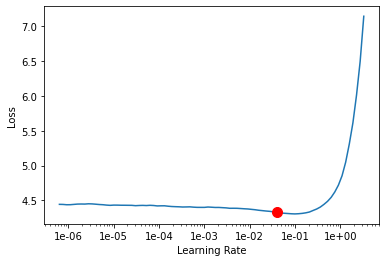

In [11]:
learn.lr_find() # find best rate
learn.recorder.plot(suggestion=True) # plot it

Fetch the optimal rate as follows.

In [12]:
rate = learn.recorder.min_grad_lr
print(rate)

0.03981071705534969


We fine-tune using slanted trangular learning rates, which are already built into the *fit_one_cycle()* method in fast.ai

In [13]:
learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,time
0,4.160126,3.791854,0.334833,00:26


### Discriminative Fine-Tuning

The call *learn.unfreeze()* makes all the layers trainable. We can use the *slice()* function to train the last layer at a specified rate, while the layers below will have reducing learning rates. We set the lower bound of the range at two orders of magnitude smaller, i.e., divide the maximum rate by 100.

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(1, slice(rate/100,rate))

epoch,train_loss,valid_loss,accuracy,time
0,3.787332,3.654399,0.353093,00:31


As you can see, the accuracy slightly increased!

We can use the resulting language model to predict some words in a sequence using the following command (predicts next 10 words)

In [16]:
learn.predict("This is a news article about", n_words=10)

'This is a news article about Trump s staffers who visit the White'

Plausible!

Save the fine-tuned language model!

In [17]:
learn.save_encoder('fine-tuned_language_model')

## Target Task Classifier Fine-tuning

In ULMFiT, target task classifier fine-tuning is carried out using the *text_classifier_learner* class. Recall that the target task here is predicting whether a given article is "fake news" or not.

We instantiate it below, using the same settings as the language model we fine-tuned above, so we can load that fine-tuned model without issues. We also load the fine-tuned language model into the instance below.

In [18]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) # use the same settings as the language model we fine-tuned, so we can load without problems
learn.load_encoder('fine-tuned_language_model')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1400 items)
x: TextList
xxbos [ ' xxmaj syrian army seizes oilfield from xxmaj islamic xxmaj state in east : state xxup tv ' 
  ' xxup beirut ( xxmaj reuters ) - xxmaj the xxmaj syrian army and its allies recaptured an oilfield from xxmaj islamic xxmaj state near the eastern city of xxmaj deir al - xxmaj zor on xxmaj saturday in further advances against the militants , state xxup tv reported . xxmaj government forces also seized part of a main highway running from xxmaj deir al - xxmaj zor down to the city of al - xxmaj mayadeen , to which many xxmaj islamic xxmaj state militants have retreated , the xxmaj syrian xxmaj observatory for xxmaj human xxmaj rights monitoring group said . xxmaj the xxmaj syrian army this week broke through xxmaj islamic xxmaj state lines to reach a government - held enclave of xxmaj deir al - xxmaj zor besieged for years by the jihadists , and is fighting to reach a nearby air base which xxup is still sur

Figure out the learning best rate as before.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.10E-01


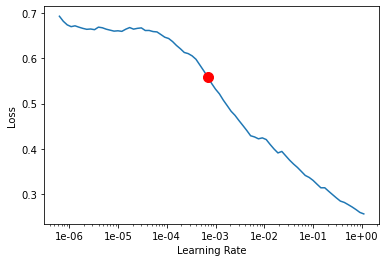

In [19]:
learn.lr_find() # find best rate
learn.recorder.plot(suggestion=True) # plot it

In [20]:
rate = learn.recorder.min_grad_lr
print(rate)

0.0006918309709189362


Train the fake news classifier

In [21]:
learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.205014,0.170096,0.995000,00:19


A nearly perfect score is achieved!

### Gradual Unfreezing
The idea is to keep the initial layers of model as untrainable in the beginning, slowly decreasing how many are untrainable as the training process proceeds.

We can use the following command to only unfreeze the last layer:

In [22]:
learn.freeze_to(-1)

We can use the following command to only unfreeze the last two layers

In [23]:
learn.freeze_to(-2)

Thus, gradual unfreezing to a depth=2 would involve doing something like this:

In [24]:
depth = 2
for i in range(1,depth+1): # freeze progressively fewer layers, up to a depth of 2, training for one cycle each time
    learn.freeze_to(-i)
    learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.112249,0.026231,0.998333,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.089079,0.008650,1.000000,00:20


Looks like we actually achieved the perfect score here! These results speak for themselves!